# Plotting CUES and GOES data

Make an example plot of ground-based CUES observations of downward longwave radiation, snow-surface temperature, and sun/no-sun flag against GOES ~11 micron band brightness temperature observations.

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import datetime as dt
import xarray as xr
import scipy

%matplotlib inline

In [109]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    # https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles 

---
## Open data files

Open the CUES temperature data files, and concatenate them together

In [110]:
directory = r'\\j-lundquist-3.ce.washington.edu\storage\CUES\Level 1 - Database\temperature'
cues_temp_files = getListOfFiles(directory)

In [111]:
cues_temp_data = []
_ = [cues_temp_data.append(pd.read_csv(i)) for i in cues_temp_files]
cues_temp_data = pd.concat(cues_temp_data)

In [112]:
# Convert the 'DateTime' text strings to pandas datetime objects
cues_temp_data['datetime']  = pd.to_datetime(cues_temp_data['MeasDateTime'])


Convert pandas dataframe to xarray dataset and and make our local time datetimes the index

In [113]:
_cues_temp_data = cues_temp_data.set_index('datetime')
_cues_temp_data.sort_index(inplace=True)
cues_ds = _cues_temp_data.to_xarray()

# drop old time field
cues_ds = cues_ds.drop_vars(names='MeasDateTime')

Open CUES radiation data file(s):

In [124]:
directory = r'\\j-lundquist-3.ce.washington.edu\storage\CUES\Level 1 - Database\radiation'
cues_rad_files = getListOfFiles(directory)

In [125]:
cues_rad_data = []
_ = [cues_rad_data.append(pd.read_csv(i)) for i in cues_rad_files]
cues_rad_data = pd.concat(cues_rad_data)

In [126]:
# Convert the 'DateTime' text strings to pandas datetime objects
cues_rad_data['datetime']  = pd.to_datetime(cues_rad_data['MeasDateTime'])

Convert pandas dataframe to xarray dataset and and make our local time datetimes the index

In [127]:
_cues_rad_data = cues_rad_data.set_index('datetime')
_cues_rad_data.sort_index(inplace=True)
cues_rad = _cues_rad_data.to_xarray()
cues_rad = cues_rad.drop_vars(names='MeasDateTime')

Load GOES observations for the CUES site

In [128]:
directory = r'\\j-lundquist-3.ce.washington.edu\storage\GOES\pkl\CUES'
goes_files = getListOfFiles(directory)

In [129]:
goes = []
_ = [goes.append(pd.read_pickle(i)) for i in goes_files]
goes = pd.concat(goes)

In [130]:
# Change GOES time values from UTC to UTC-7 for CUES site:
goes = goes.rename(columns={'time': 'timeUTC'})
goes['datetime'] = goes['timeUTC'] - pd.Timedelta(hours=7)
goes = goes.drop(columns=['timeUTC'])

Convert pandas dataframe to xarray dataset and and make our local time datetimes the index

In [131]:
_goes = goes.set_index('datetime')
_goes.sort_index(inplace=True)
_goes = _goes.loc[~_goes.index.duplicated(keep='first')] # there are duplicates somewhere in the GOES data, remove them
_goes = _goes.loc[_goes.index >= pd.datetime(2017,2,28)]# there's also some values before 2017, remove them
goes_ds = _goes.to_xarray()

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  after removing the cwd from sys.path.


Load MODIS observations of the CUES site

In [132]:
#modis_1 = pd.read_pickle('./MODIS_data/cues_2017_1-59.pkl')
#modis_2 = pd.read_pickle('./MODIS_data/cues_2017_60-120.pkl')
#
## Concatenate the two MODIS time series together
#modis = pd.concat([modis_1, modis_2], ignore_index=True)

When do we have ASTER observations of this site?

In [136]:
#aster = pd.read_csv(r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\MountainGOES\Tuolumne2017\aster datetimes.csv')

---
## Make example plot

Set font sizes for plots

In [133]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

[]

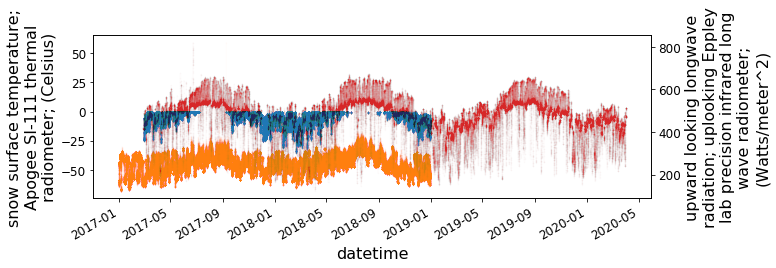

In [134]:
# quick preview plot to see what time period of GOES and CUES data we have
f, ax = plt.subplots(figsize=(10,3))
goes_ds.tb.plot(c='tab:red', linestyle='-', marker='.', markersize='2', ax=ax, alpha=0.01)
cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].plot(c='tab:blue', linestyle='-', marker='.', markersize='2', ax=ax, alpha=0.01)
ax2 = ax.twinx()
cues_rad['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)'].plot(c='tab:orange', linestyle='-', marker='.', markersize='2', ax=ax2, alpha=0.01)
plt.plot()

Resample all of these to hourly means, ignoring any nan values

In [135]:
# Resample CUES to hourly mean CUES Tss
cues_ds = cues_ds.resample(datetime='1H').reduce(np.nanmean)

# Resample CUES to hourly mean CUES Tss
cues_rad = cues_rad.resample(datetime='1H').reduce(np.nanmean)

# Resample CUES to hourly mean CUES Tss
goes_ds = goes_ds.resample(datetime='1H').reduce(np.nanmean)

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\xarray\core\variable.py:1575: RuntimeWarning: Mean of empty slice
  data = func(input_data, axis=axis, **kwargs)


select only the overlapping time period we want

In [ ]:
cues_ds = cues_ds.sel(datetime=slice('2017-03-01', '2018-12-31'))
cues_rad = cues_rad.sel(datetime=slice('2017-03-01', '2018-12-31'))
goes_ds = goes_ds.sel(datetime=slice('2017-03-01', '2018-12-31'))

plot again

[]

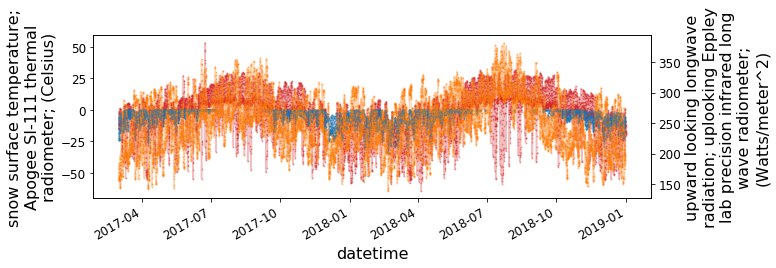

In [144]:
# quick preview plot to see what time period of GOES and CUES data we have
f, ax = plt.subplots(figsize=(10,3))
goes_ds.tb.plot(c='tab:red', linestyle='-', marker='.', markersize='2', ax=ax, alpha=0.3)
cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].plot(c='tab:blue', linestyle='-', marker='.', markersize='2', ax=ax, alpha=0.3)
ax2 = ax.twinx()
cues_rad['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)'].plot(c='tab:orange', linestyle='-', marker='.', markersize='2', ax=ax2, alpha=0.3)
plt.plot()

---
### Compute an idealized "clear-sky" downward longwave radiation:
(using Dilley and O’Brien (1998))

In [145]:
RH = cues_ds['Platform relative humidity; platform temperature/relative humidity; (percent)']
T = cues_ds['Platform temperature; platform temperature/relative humidity; (degrees Celsius)']
T0 = T + 273.15 # temperature [K]

#es = 6.11 * 10**((7.5*T)/(T+273.15)) # saturated vapor pressure [hPa]
es = 6.108 * np.exp(17.27 * T / (T + 237.3)) # saturated vapor pressure [hPa]

e0 = (RH/100 * es) / 10 # actual vapor pressure [kPa]

w = (4650 * e0) / T0 # from Prata (1996)

Lclr = 59.38 + 113.7*(T0/273.16)**6 + 96.96*np.sqrt(w/25) # clear sky downward longwave radiation from Dilley and O'Brien (1998)

cues_ds['Lclr'] = Lclr

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  This is separate from the ipykernel package so we can avoid doing imports until


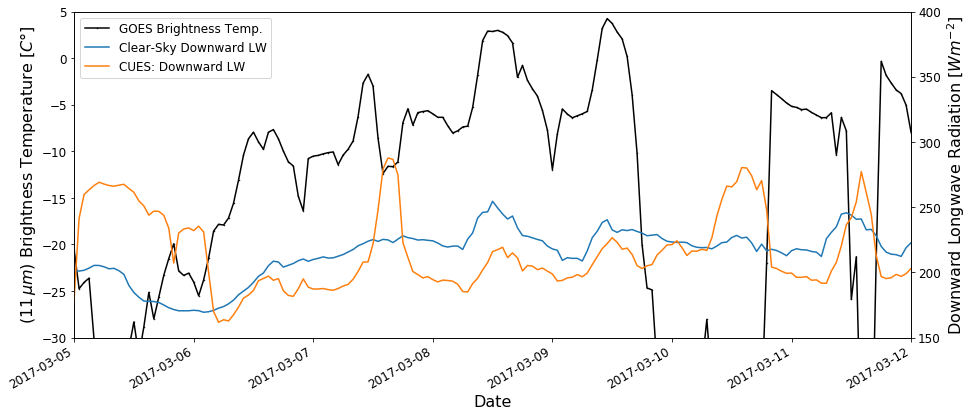

In [224]:
# Set start and end dates for time period we want to look at
startdate = pd.datetime(2017,3,5)
enddate = pd.datetime(2017,3,12)

fig, ax = plt.subplots(figsize=(15,6))


ax2 = ax.twinx()

# Estimated Clear-Sky Downward Longwave Radiation
cues_ds['Lclr'].plot(ax=ax2)

# Observed Downward Lognwave Radiation
cues_rad['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)'].plot(ax=ax2)

# Fill in areas CUES identifies as sunny versus not sunny
#sun_flag = cues_rad['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)'] == 1
#cues_nosun = ax2.fill_between(cues_rad_data.datetime, 1000, y2=0, where=~sun_flag, color='lightgrey',alpha=0.1)
#cues_sun = ax2.fill_between(cues_rad_data.datetime, 1000, y2=0, where=sun_flag, color='lightyellow',alpha=0.1)

#cloud_flag = cues_ds['Lclr'] < cues_rad['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']
#cloud = ax.fill_between(cues_rad_data.datetime, 1000, y2=0, where=cloud_flag, color='red',alpha=0.1)

# GOES brightness temperature
goes_ds.tb.plot(c='k', linestyle='-', marker='.', markersize=1, ax=ax)

#ax.set_xlim((cues_rad.datetime.min(),cues_rad.datetime.max()))
ax.set_xlim([startdate,enddate])
ax2.set_ylim((150,400))
ax.set_ylim((-30,5))

ax.set_ylabel('($11 \, \mu m$) Brightness Temperature [$C\degree$]')
ax.set_xlabel('Date')
ax2.set_ylabel('Downward Longwave Radiation [$W m^{-2}$]')

# make legend
lines = [ax.lines[0], ax2.lines[0], ax2.lines[1]]
labels = ['GOES Brightness Temp.', 'Clear-Sky Downward LW', 'CUES: Downward LW']
ax.legend(lines, labels, loc='upper left')

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  This is separate from the ipykernel package so we can avoid doing imports until


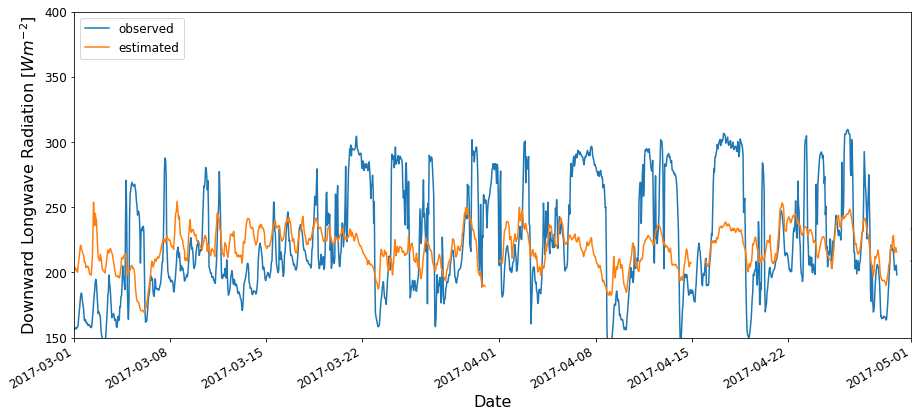

In [232]:
# Set start and end dates for time period we want to look at
startdate = pd.datetime(2017,3,1)
enddate = pd.datetime(2017,5,1)

fig, ax = plt.subplots(figsize=(15,6))

# Observed Downward Lognwave Radiation
cues_rad['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)'].plot(ax=ax)


# Estimated Clear-Sky Downward Longwave Radiation
cues_ds['Lclr'].plot(ax=ax)


# Fill in areas CUES identifies as sunny versus not sunny
#sun_flag = cues_rad['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)'] == 1
#cues_nosun = ax2.fill_between(cues_rad_data.datetime, 1000, y2=0, where=~sun_flag, color='lightgrey',alpha=0.1)
#cues_sun = ax2.fill_between(cues_rad_data.datetime, 1000, y2=0, where=sun_flag, color='lightyellow',alpha=0.1)

#cloud_flag = cues_ds['Lclr'] < cues_rad['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']
#cloud = ax.fill_between(cues_rad_data.datetime, 1000, y2=0, where=cloud_flag, color='red',alpha=0.1)

#ax.set_xlim((cues_rad.datetime.min(),cues_rad.datetime.max()))
ax.set_xlim([startdate,enddate])
ax.set_ylim((150,400))


ax.set_xlabel('Date')
ax.set_ylabel('Downward Longwave Radiation [$W m^{-2}$]')

# make legend
lines = [ax.lines[0], ax.lines[1]]
labels = [ 'observed', 'estimated']
ax.legend(lines, labels, loc='upper left')

0.47326016144684896


Text(0.5, 0, 'LWd Observed [$Wm^{-2}$]')

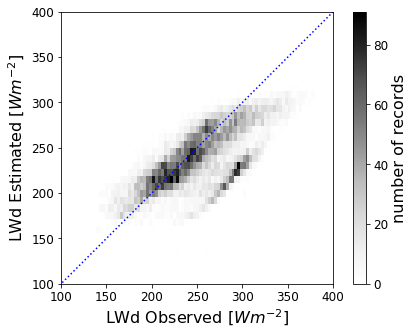

In [222]:


plt.figure(figsize=(7,5))

x = cues_rad['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']
y = cues_ds['Lclr']

df1 = pd.DataFrame({'x': x})
df1['y'] = y
df1 = df1.dropna()
x = df1.x
y = df1.y

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
fit = slope*x + intercept

print(r_value**2)

heatmap, xedges, yedges = np.histogram2d(x, y, bins=75)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='Greys')
plt.colorbar(label='number of records')
#plt.plot(x, fit, ':r')


#plt.plot(x,y,'.k',alpha=0.05)

plt.plot([0,400],[0,400],':b')

plt.xlim([100,400])
plt.ylim([100,400])

plt.ylabel('LWd Estimated [$Wm^{-2}$]')
plt.xlabel('LWd Observed [$Wm^{-2}$]')

---
## Make some plots
Plot CUES snow surface temperature, CUES downward longwave, GOES 11 micron band brightness temperature

---
Find matching CUES and GOES observations.

CUES snow-surface temperature is a 1-minute observations, GOES is 5- or 10-minute (?). So first aggregate both into hourly mean temperatures:

In [191]:
## Resample CUES to hourly mean CUES Tss
#cues_ds_1h = cues_ds.resample(datetime='1H').reduce(np.nanmean)
#
## Resample CUES to hourly mean CUES Tss
#cues_rad_1h = cues_rad.resample(datetime='1H').reduce(np.nanmean)
#
## Resample CUES to hourly mean CUES Tss
#goes_ds_1h = goes_ds.resample(datetime='1H').reduce(np.nanmean)


cues_ds_1h = cues_ds
cues_rad_1h = cues_rad
goes_ds_1h = goes_ds

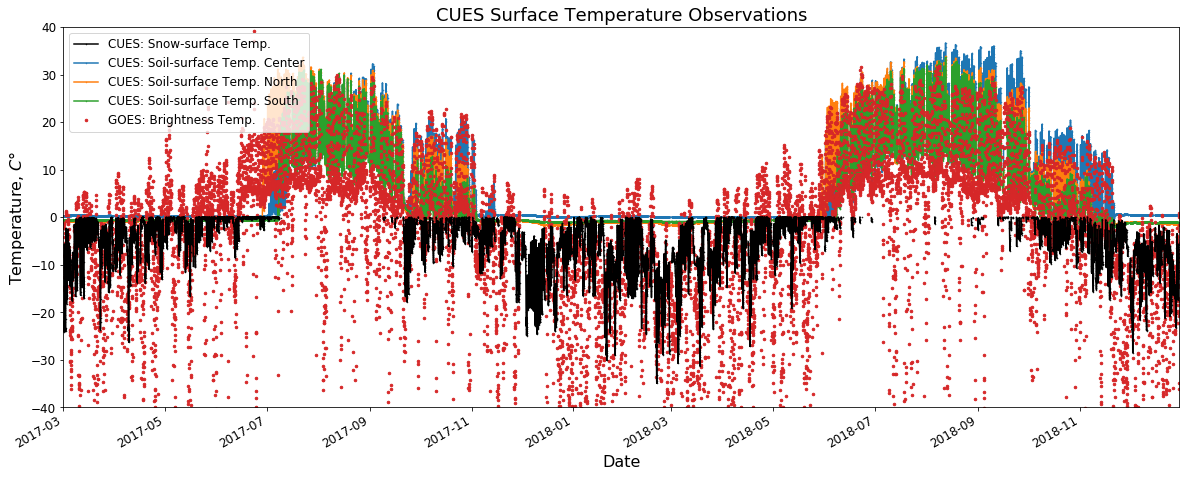

In [192]:
# Set start and end dates for time period we want to look at
startdate = cues_ds.datetime.min().values
enddate = cues_ds.datetime.max().values

# Set up figure
fig, ax = plt.subplots(figsize=(20,7))

# Plot CUES snow surface temperature
cues_ds_1h['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].plot(
    c='k', marker='.', ax=ax, markersize=1, linestyle='-', zorder=99)

# Plot CUES soil surface temperature
cues_ds_1h['soil temperature @ 0cm; soil temp at 0cm  center; (degrees Celsius)'].plot(ax=ax, linestyle='-', marker='.', markersize=1)
cues_ds_1h['soil temp at 0cm  north; soil thermistor at 0cm  north; (deg C)'].plot(ax=ax, linestyle='-', marker='.', markersize=1)
cues_ds_1h['soil temp at 0cm  south; soil thermistor at 0cm  south; (deg C)'].plot(ax=ax, linestyle='-', marker='.', markersize=1)

# Plot GOES brightness temperature
goes_ds_1h.tb.plot(c='tab:red', linestyle='none', marker='.', markersize=5, ax=ax)

# Plot MODIS
#modis_temp = modis.plot(x='datetime',y='temp_mean', marker='s',c='r',linestyle='None',ax=ax)
# MODIS error bars
#ax.errorbar(modis.datetime,modis.temp_mean,
#             yerr=[np.abs(modis.temp_min-modis.temp_mean),abs(modis.temp_max-modis.temp_mean)],
#             linestyle='None',c='r',linewidth=2,capsize=4,alpha=0.5)


# Format axes
#from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
#                               AutoMinorLocator)
#myFmt = mdates.DateFormatter('%D')
#ax.xaxis.set_minor_locator(MultipleLocator(1/24))
#ax.xaxis.set_major_locator(MultipleLocator(1))
#ax.xaxis.set_major_formatter(myFmt)
#ax.tick_params(axis='x', labelrotation=0) 
ax.set_xlim([startdate,enddate])
ax.set_ylim([-40,40])
ax.set_ylabel('Temperature, $C\degree$')
ax.set_xlabel('Date')

# Make legend
lines = [ax.lines[0], ax.lines[1], ax.lines[2], ax.lines[3], ax.lines[4]]
labels = ['CUES: Snow-surface Temp.', 
          'CUES: Soil-surface Temp. Center', 
          'CUES: Soil-surface Temp. North', 
          'CUES: Soil-surface Temp. South',
          'GOES: Brightness Temp.']
ax.legend(lines, labels, loc='upper left')

# Set title
plt.title('CUES Surface Temperature Observations');

# Save figure image
#plt.savefig('goes-vs-cues-2017.jpg',dip=300);

I think soil temperatures < 1 C are typically burried in snow, so I will set these to Nan values for now:

In [193]:
soil_t_threshold = 1

Then for each CUES observation of snow-surface temperature, find the nearest GOES observation:

In [194]:
# Find nearest GOES Tb observation given a CUES datetime
_goes_ds = goes_ds_1h.sel(datetime=cues_ds_1h.datetime)
cues_ds_1h['goes_tb_c'] = _goes_ds.tb

Text(0.5, 1.0, 'GOES-16 ABI Band 14 ($11.2 \\mu m$)\nand CUES Ground-based Observations')

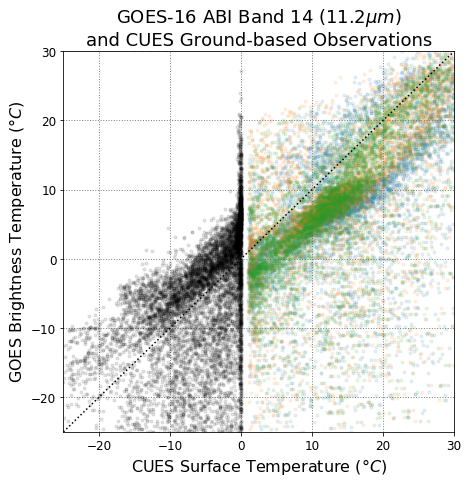

In [195]:
plt.figure(figsize=(7,7))
# gridlines
plt.grid(color='grey', linestyle=':', linewidth=1)

# GOES Tb vs snow temp
plt.plot(cues_ds_1h['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'],
         cues_ds_1h.goes_tb_c,
         '.k',alpha=0.1)

# GOES Tb vs soil temp
plt.plot(cues_ds_1h['soil temp at 0cm  north; soil thermistor at 0cm  north; (deg C)'].where(cues_ds_1h['soil temp at 0cm  north; soil thermistor at 0cm  north; (deg C)'] > soil_t_threshold),
         cues_ds_1h.goes_tb_c.where(cues_ds_1h['soil temp at 0cm  north; soil thermistor at 0cm  north; (deg C)'] > soil_t_threshold),
         '.',alpha=0.1)
plt.plot(cues_ds_1h['soil temp at 0cm  south; soil thermistor at 0cm  south; (deg C)'].where(cues_ds_1h['soil temp at 0cm  south; soil thermistor at 0cm  south; (deg C)'] > soil_t_threshold),
         cues_ds_1h.goes_tb_c.where(cues_ds_1h['soil temp at 0cm  south; soil thermistor at 0cm  south; (deg C)'] > soil_t_threshold),
         '.',alpha=0.1)
plt.plot(cues_ds_1h['soil temperature @ 0cm; soil temp at 0cm  center; (degrees Celsius)'].where(cues_ds_1h['soil temperature @ 0cm; soil temp at 0cm  center; (degrees Celsius)'] > soil_t_threshold),
         cues_ds_1h.goes_tb_c.where(cues_ds_1h['soil temperature @ 0cm; soil temp at 0cm  center; (degrees Celsius)'] > soil_t_threshold),
         '.',alpha=0.1)

plt.ylabel('GOES Brightness Temperature ($\degree C$)')
plt.xlabel('CUES Surface Temperature ($\degree C$)')
plt.xlim([-25,30])
plt.ylim([-25,30])

# 1-to-1 line for reference
plt.plot([-25,30],[-25,30],'k:')

# add legend
#plt.legend()

# zero lines for reference
#plt.plot([-25,20],[0,0],':',c='lightgrey')
#plt.plot([0,0],[-25,20],':',c='lightgrey')

plt.title('GOES-16 ABI Band 14 ($11.2 \mu m$)\nand CUES Ground-based Observations')

Compute some stats

Tb vs snow

r-squared = 0.05423967000257172


Text(0.5, 0, 'CUES Snow-Surface Temp. [$\\degree C$]')

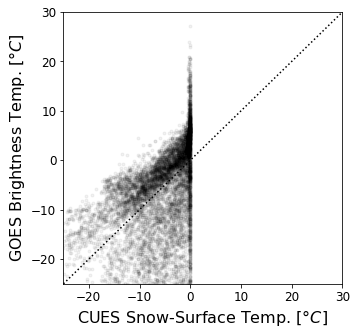

In [216]:
       

plt.figure(figsize=(5,5))

x = cues_ds_1h['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']
y = cues_ds_1h.goes_tb_c

df1 = pd.DataFrame({'x': x})
df1['y'] = y
df1 = df1.dropna()
x = df1.x
y = df1.y

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
fit = slope*x + intercept

print('r-squared = {}'.format(r_value**2))

heatmap, xedges, yedges = np.histogram2d(x, y, bins=75)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


#plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='Greys')
#plt.colorbar(label='number of records')
#plt.plot(x, fit, ':r')


plt.plot(x,y,'.k',alpha=0.05)

plt.plot([-25,30],[-25,30],':k')

plt.xlim([-25,30])
plt.ylim([-25,30])

plt.ylabel('GOES Brightness Temp. [$\degree C$]')
plt.xlabel('CUES Snow-Surface Temp. [$\degree C$]')

GOES Tb vs soil temps

r-squared = 0.18458760246758654


Text(0.5, 0, 'CUES Snow-Surface Temp. [$\\degree C$]')

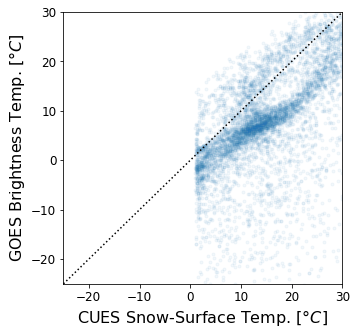

In [217]:
      

plt.figure(figsize=(5,5))

x = cues_ds_1h['soil temp at 0cm  north; soil thermistor at 0cm  north; (deg C)'].where(cues_ds_1h['soil temp at 0cm  north; soil thermistor at 0cm  north; (deg C)'] > soil_t_threshold)
y = cues_ds_1h.goes_tb_c.where(cues_ds_1h['soil temp at 0cm  north; soil thermistor at 0cm  north; (deg C)'] > soil_t_threshold)


df1 = pd.DataFrame({'x': x})
df1['y'] = y
df1 = df1.dropna()
x = df1.x
y = df1.y

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
fit = slope*x + intercept

print('r-squared = {}'.format(r_value**2))

heatmap, xedges, yedges = np.histogram2d(x, y, bins=75)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


#plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='Greys')
#plt.colorbar(label='number of records')
#plt.plot(x, fit, ':r')


plt.plot(x,y,'.',c='tab:blue',alpha=0.05)

plt.plot([-25,30],[-25,30],':k')

plt.xlim([-25,30])
plt.ylim([-25,30])

plt.ylabel('GOES Brightness Temp. [$\degree C$]')
plt.xlabel('CUES Soil-Surface Temp. (north) [$\degree C$]')

r-squared = 0.18866113214143435


Text(0.5, 0, 'CUES Soil-Surface Temp. (south) [$\\degree C$]')

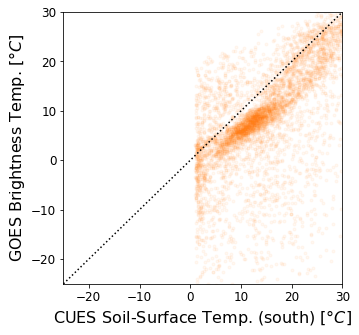

In [219]:
      

plt.figure(figsize=(5,5))

x = cues_ds_1h['soil temp at 0cm  south; soil thermistor at 0cm  south; (deg C)'].where(cues_ds_1h['soil temp at 0cm  south; soil thermistor at 0cm  south; (deg C)'] > soil_t_threshold)
y = cues_ds_1h.goes_tb_c.where(cues_ds_1h['soil temp at 0cm  south; soil thermistor at 0cm  south; (deg C)'] > soil_t_threshold)

df1 = pd.DataFrame({'x': x})
df1['y'] = y
df1 = df1.dropna()
x = df1.x
y = df1.y

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
fit = slope*x + intercept

print('r-squared = {}'.format(r_value**2))

heatmap, xedges, yedges = np.histogram2d(x, y, bins=75)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


#plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='Greys')
#plt.colorbar(label='number of records')
#plt.plot(x, fit, ':r')


plt.plot(x,y,'.',c='tab:orange',alpha=0.05)

plt.plot([-25,30],[-25,30],':k')

plt.xlim([-25,30])
plt.ylim([-25,30])

plt.ylabel('GOES Brightness Temp. [$\degree C$]')
plt.xlabel('CUES Soil-Surface Temp. (south) [$\degree C$]')

r-squared = 0.23618942781010926


Text(0.5, 0, 'CUES Soil-Surface Temp. (center) [$\\degree C$]')

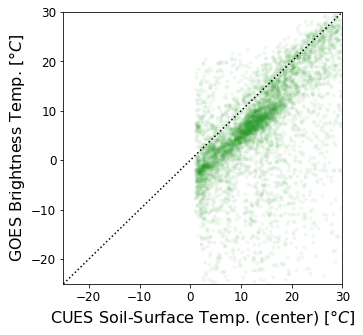

In [220]:
      

plt.figure(figsize=(5,5))

x = cues_ds_1h['soil temperature @ 0cm; soil temp at 0cm  center; (degrees Celsius)'].where(cues_ds_1h['soil temperature @ 0cm; soil temp at 0cm  center; (degrees Celsius)'] > soil_t_threshold)
y = cues_ds_1h.goes_tb_c.where(cues_ds_1h['soil temperature @ 0cm; soil temp at 0cm  center; (degrees Celsius)'] > soil_t_threshold)
    
df1 = pd.DataFrame({'x': x})
df1['y'] = y
df1 = df1.dropna()
x = df1.x
y = df1.y

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
fit = slope*x + intercept

print('r-squared = {}'.format(r_value**2))

heatmap, xedges, yedges = np.histogram2d(x, y, bins=75)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


#plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='Greys')
#plt.colorbar(label='number of records')
#plt.plot(x, fit, ':r')


plt.plot(x,y,'.',c='tab:green',alpha=0.05)

plt.plot([-25,30],[-25,30],':k')

plt.xlim([-25,30])
plt.ylim([-25,30])

plt.ylabel('GOES Brightness Temp. [$\degree C$]')
plt.xlabel('CUES Soil-Surface Temp. (center) [$\degree C$]')

---

------

Text(0.5, 0, 'Hour of Day')

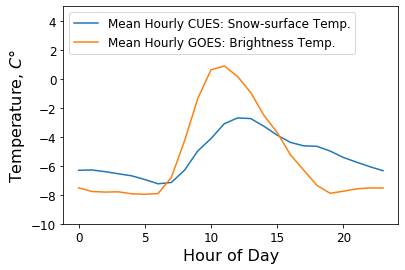

In [205]:
fig, ax = plt.subplots()
cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].groupby('datetime.hour').mean().plot(ax=ax)
goes_ds.tb.groupby('datetime.hour').mean().plot(ax=ax)

# Make legend
lines = [ax.lines[0], ax.lines[1]]
labels = ['Mean Hourly CUES: Snow-surface Temp.', 'Mean Hourly GOES: Brightness Temp.']
ax.legend(lines, labels, loc='upper left')

ax.set_ylim([-10,5])
ax.set_ylabel('Temperature, $C\degree$')
ax.set_xlabel('Hour of Day')

In [ ]:
# Compute the difference in temperatures (GOES - CUES)
delta_t = []
cues_tss = []
goes_tb = []

_goes_time = goes_ds.datetime

#times = (_goes_time > np.min(_cues_time)) & (_goes_time < np.max(_cues_time))

In [ ]:
plt.plot(c.datetime,times)


In [ ]:
for t in _goes_time[times]:
    print(t)
    goes_time = (nearest(_goes_time,t))
    tb = _goes_tb[_goes_time == goes_time]
    goes_tb.append(tb)
    
    tss = _cues_tss[_cues_time==t]
    cues_tss.append(tss)

    
    delta_t.append(tb - tss)


In [ ]:
# make a dict with all the data
d = {'datetime': _goes_time[times], 
     'goes_tb': goes_tb, 
     'cues_tss': cues_tss,
     'delta_t': delta_t
     }
# make the dict a pandas dataframe
goes_vs_insitu = pd.DataFrame(data=d)


goes_vs_insitu

# Export this the dataframe to a pickle file
goes_vs_insitu.to_pickle("goes16-vs-cues_02-2017-08-2017.pkl", protocol=3)